In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

In [2]:
## RANSAC for 2D line fitting

In [3]:
def model_error(theta, data):
    m = theta[0]
    c = theta[1]
    y_predicted = m * data[:,0] + c
    e = y_predicted - data[:,1]
    return np.sum(np.square(e))   

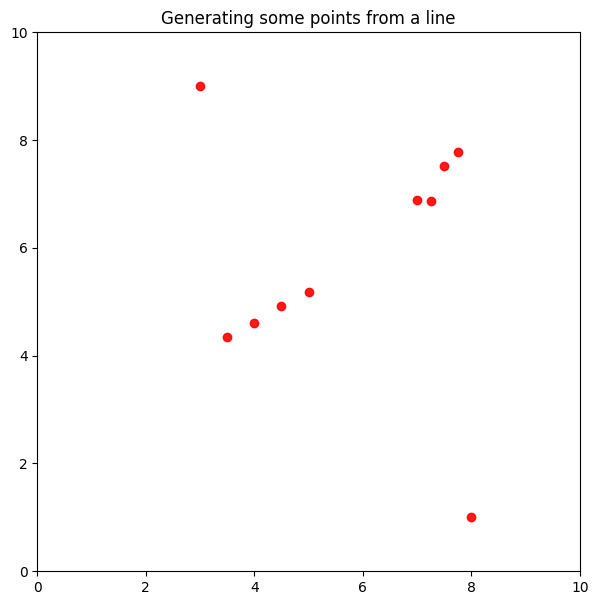

In [4]:
# Generate some data
np.random.seed(0)

m_true = .75
c_true = 1

x = np.hstack([np.linspace(3, 5, 5), np.linspace(7, 8, 5)])
y = m_true * x + c_true + np.random.rand(len(x))

# Outliers
y[9] = 1
y[0] = 9

data = np.vstack([x, y]).T
n = data.shape[0]

plt.figure(figsize=(7,7))
plt.scatter(data[:,0], data[:,1], c='red', alpha=0.9)
plt.xlim([0,10])
plt.ylim([0,10])
plt.title('Generating some points from a line');

In [5]:
def draw_line(theta, ax, **kwargs):
    m = theta[0]
    c = theta[1]
    
    xmin, xmax = ax.get_xbound()
    
    ymin = m * xmin + c
    ymax = m * xmax + c
        
    l = mlines.Line2D([xmin, xmax], [ymin,ymax], **kwargs)
    ax.add_line(l)

In [6]:
# Implementation 1

In [7]:
np.random.seed(0)

num_iterations = 32

runs = []
for i in range(num_iterations):
    
    # Randomly selecting enough points needed to fit the model
    idx = np.zeros(2)
    while idx[0] == idx[1]: 
        idx = (np.random.rand(2)*n).astype(int)
    data_for_this_fit = data[idx,:]
    
    # Model fitting
    theta = np.polyfit(data_for_this_fit[:,0], data_for_this_fit[:, 1], 1)
    
    # Computing model fit error
    error = model_error(theta, data)
    
    # Storing the results
    runs.append(
        {
            'iteration': i,
            'data_used': data_for_this_fit,
            'theta': theta,
            'error': error
        }
    )

In [8]:
print(f'#runs = {len(runs)}')

#runs = 32


In [9]:
sorted_runs = sorted(runs, key=lambda k: k['error'])

In [10]:
theta_final = sorted_runs[0]['theta']
error_final = sorted_runs[0]['error']

In [11]:
print(f'theta_final = {theta_final}')
print(f'error_final = {error_final}')

theta_final = [0.50754323 2.63593864]
error_final = 59.31971147802791


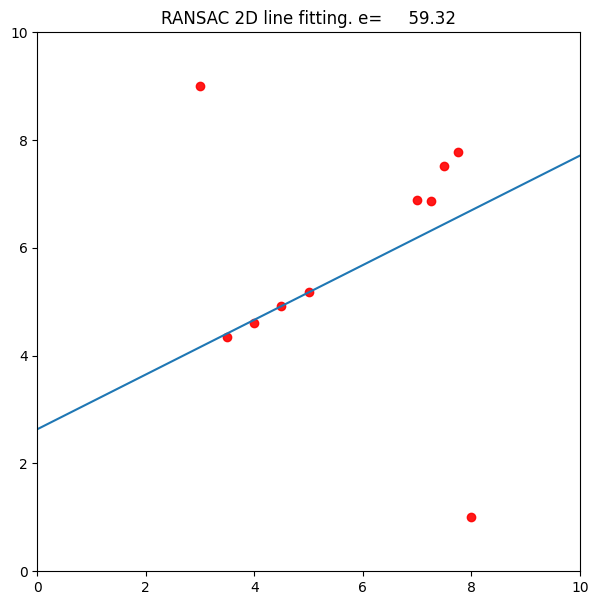

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(data[:,0], data[:,1], c='red', alpha=0.9)
plt.xlim([0,10])
plt.ylim([0,10])
plt.title(f'RANSAC 2D line fitting. e={error_final:10.5}');
draw_line(theta_final, plt.gca())

In [13]:
# Visualization 1

In [14]:
def plot_fitted_line(ax, theta, data_used, error, count, data_explained, i, **kwargs):
    ax.scatter(data[:,0], data[:,1], c='red', alpha=0.3)
    ax.scatter(data_used[:,0], data_used[:,1], c='blue', alpha=0.9)
    if data_explained is not None:
        ax.scatter(data_explained[:,0], data_explained[:,1], c='green', alpha=0.5)
    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    if count == -1:
        ax.set_title(f'RANSAC line fitting. #={i}. e={error:10.5}');    
    else:
        ax.set_title(f'RANSAC line fitting. #={i}. e={error:10.5}. c={count}');    
    draw_line(theta, ax, **kwargs)

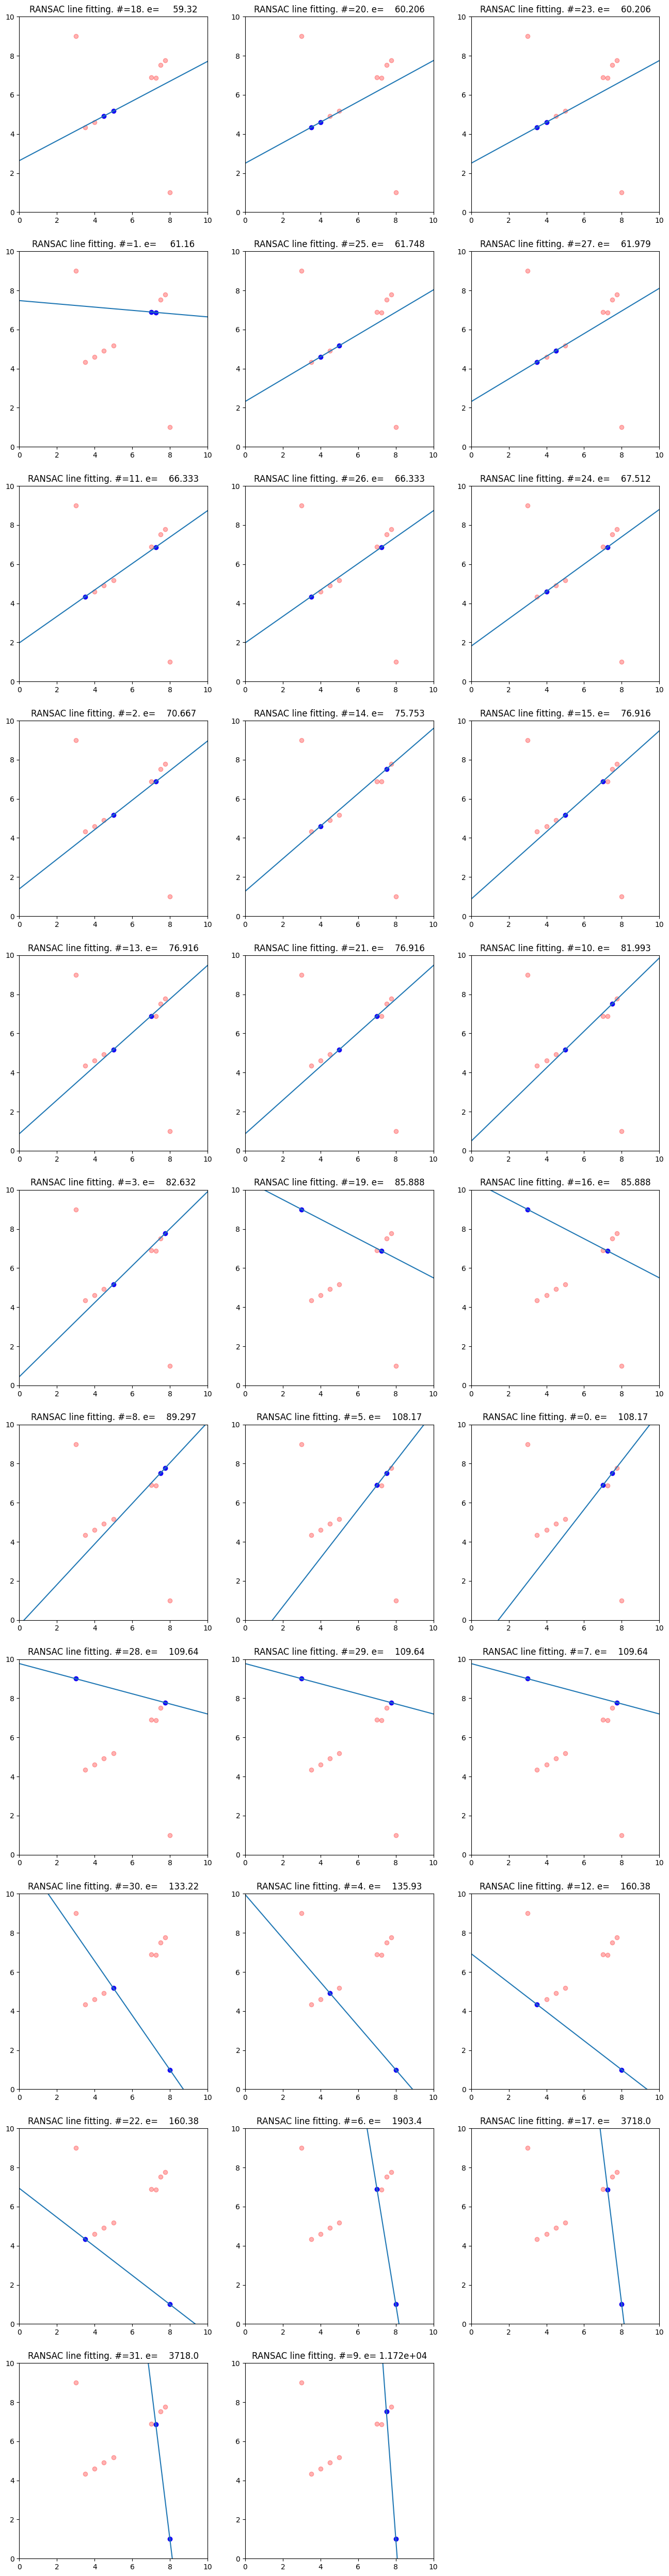

In [15]:
fig = plt.figure(figsize=(16, num_iterations*2))
for i in range(num_iterations):
    ax = fig.add_subplot(int(np.ceil(num_iterations/3)),3,i+1)
    theta = sorted_runs[i]['theta']
    data_used = sorted_runs[i]['data_used']
    error = sorted_runs[i]['error']
    itr = sorted_runs[i]['iteration']
    plot_fitted_line(ax, theta, data_used, error, -1, None, itr)

In [16]:
# Implementation 2

In [17]:
def model_error_with_count(theta, data, scale):
    m = theta[0]
    c = theta[1]
    y_predicted = m * data[:,0] + c
    e2 = np.square(y_predicted - data[:,1])
    pts_explained = e2 < scale
    
    return np.sum(e2[pts_explained]), np.sum(pts_explained), pts_explained

In [18]:
np.random.seed(0)

num_iterations = 32
scale = 3

runs = []
for i in range(num_iterations):
    
    # Randomly selecting enough points needed to fit the model
    idx = np.zeros(2)
    while idx[0] == idx[1]: 
        idx = (np.random.rand(2)*n).astype(int)
    data_for_this_fit = data[idx,:]
    
    # Model fitting
    theta = np.polyfit(data_for_this_fit[:,0], data_for_this_fit[:, 1], 1)
    
    # Computing model fit error
    error, count, pts_explained = model_error_with_count(theta, data, scale)
    
    # Storing the results
    runs.append(
        {
            'iteration': i,
            'data_used': data_for_this_fit,
            'theta': theta,
            'error': error,
            'count': count,
            'data_explained': data[pts_explained,:]
        }
    )

In [19]:
print(f'#runs={len(runs)}')

#runs=32


In [20]:
sorted_runs = sorted(runs, key=lambda k: k['count'])
count_final = sorted_runs[-1]['count']

In [21]:
print(f'count_final={count_final}')

count_final=8


In [22]:
runs_with_count = [v for v in sorted_runs if v['count'] == count_final]

In [23]:
print(f'Found #runs {len(runs_with_count)} with count {count_final}')

Found #runs 16 with count 8


In [24]:
sorted_runs_with_count = sorted(runs_with_count, key=lambda k: k['error'])

In [25]:
theta_final = sorted_runs_with_count[0]['theta']
error_final = sorted_runs_with_count[0]['error']

In [26]:
print(f'theta_final={theta_final}')
print(f'error_final={error_final}')

theta_final=[0.83257418 1.27246666]
error_final=0.33438258175997704


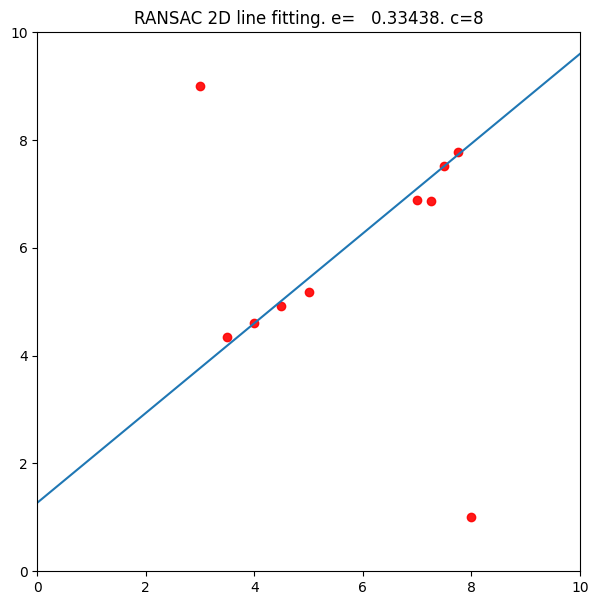

In [27]:
plt.figure(figsize=(7,7))
plt.scatter(data[:,0], data[:,1], c='red', alpha=0.9)
plt.xlim([0,10])
plt.ylim([0,10])
plt.title(f'RANSAC 2D line fitting. e={error_final:10.5}. c={count_final}');
draw_line(theta_final, plt.gca())

In [28]:
# Visualization 2

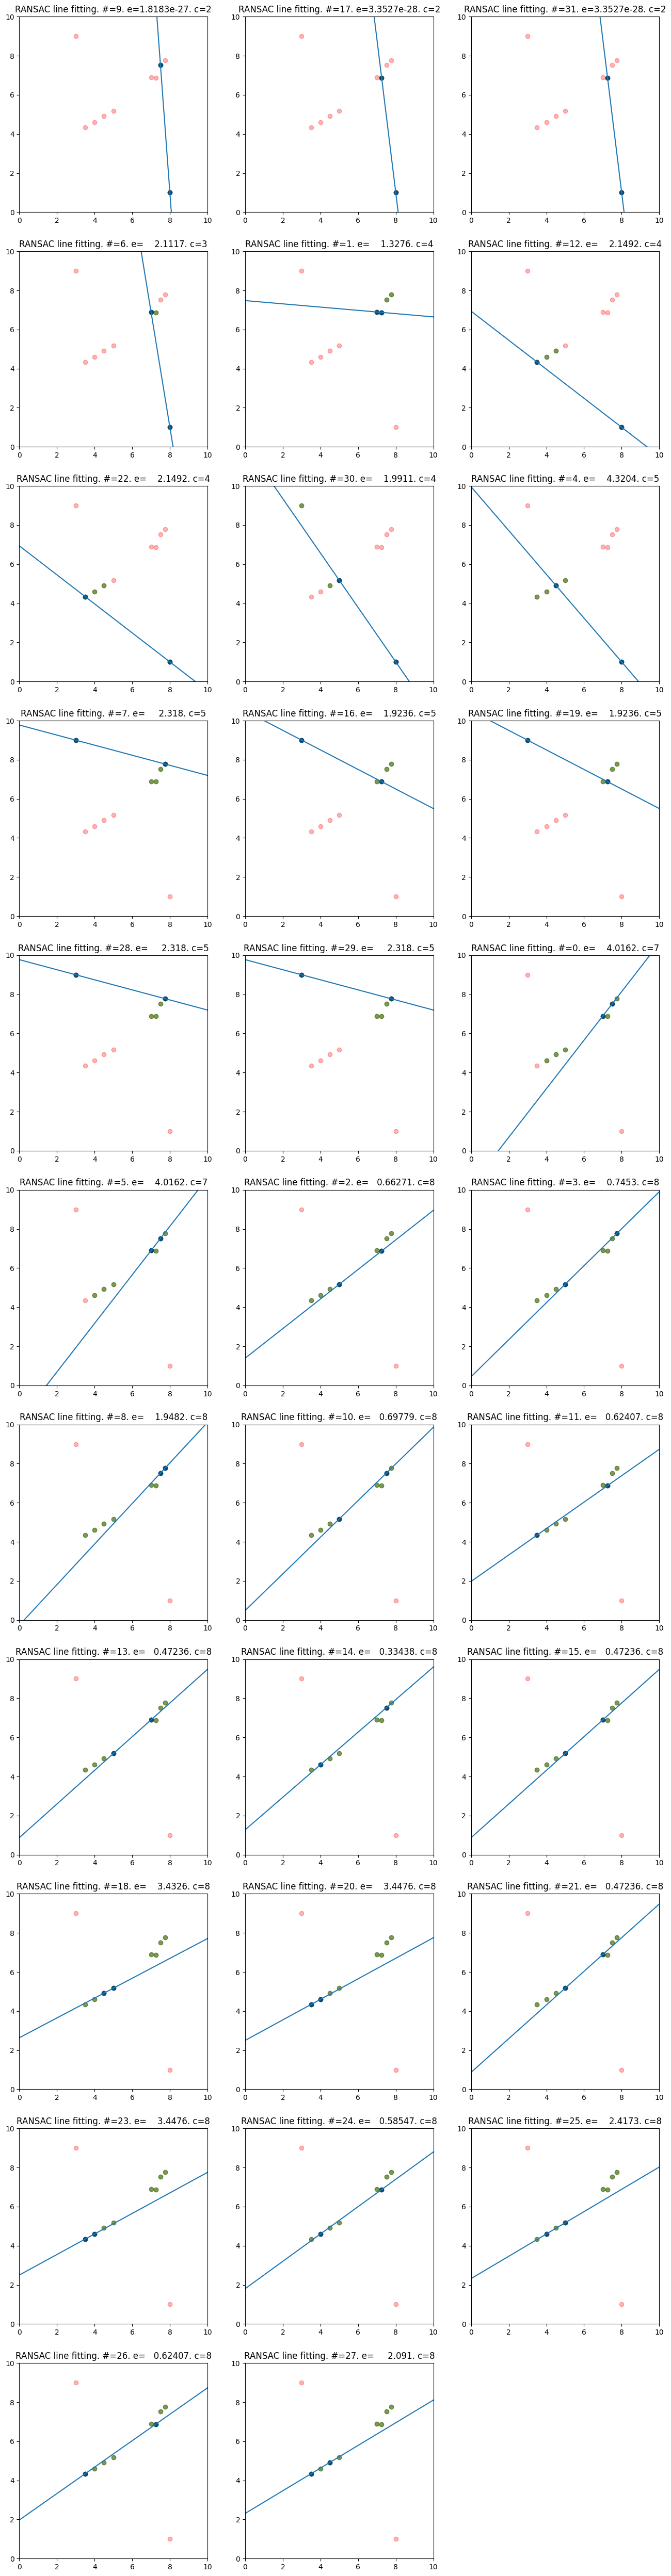

In [29]:
fig = plt.figure(figsize=(16, num_iterations*2))
for i in range(num_iterations):
    ax = fig.add_subplot(int(np.ceil(num_iterations/3)),3,i+1)
    theta = sorted_runs[i]['theta']
    data_used = sorted_runs[i]['data_used']
    error = sorted_runs[i]['error']
    count = sorted_runs[i]['count']
    data_explained = sorted_runs[i]['data_explained']
    itr = sorted_runs[i]['iteration']
    plot_fitted_line(ax, theta, data_used, error, count, data_explained, itr)

In [30]:
## RANSAC 2D line fitting

In [31]:
np.random.seed(0)

num_iterations = 120
scale = 3
data_explained = 70
early_stop = False
min_iterations = 40

runs = []
for i in range(num_iterations):
    
    # Randomly selecting enough points needed to fit the model
    idx = np.zeros(2)
    while idx[0] == idx[1]: 
        idx = (np.random.rand(2)*n).astype(int)
    data_for_this_fit = data[idx,:]
    
    # Model fitting
    theta = np.polyfit(data_for_this_fit[:,0], data_for_this_fit[:, 1], 1)
    
    # Computing model fit error
    error, count, pts_explained = model_error_with_count(theta, data, scale)
    
    # Storing the results
    runs.append(
        {
            'iteration': i,
            'data_used': data_for_this_fit,
            'theta': theta,
            'error': error,
            'count': count,
            'data_explained': data[pts_explained,:]
        }
    )
    
    # Check if the model can explain the desired % of data
    if data_explained < (count * 100 / n) and (i-1) > min_iterations:
        print(f'{data_explained}% data explained at iteration {i} (0-based).  Done.')
        early_stop = True
        break

if not early_stop:
    print(f'Done after {i} iterations.')

70% data explained at iteration 42 (0-based).  Done.


In [32]:
print(f'#runs={len(runs)}')

#runs=43


In [33]:
sorted_runs = sorted(runs, key=lambda k: k['count'])
count_final = sorted_runs[-1]['count']

In [34]:
print(f'count_final={count_final}')

count_final=8


In [35]:
runs_with_count = [v for v in sorted_runs if v['count'] == count_final]

In [36]:
print(f'Found #runs {len(runs_with_count)} with count {count_final}')

Found #runs 23 with count 8


In [37]:
sorted_runs_with_count = sorted(runs_with_count, key=lambda k: k['error'])

In [38]:
theta_final = sorted_runs_with_count[0]['theta']
error_final = sorted_runs_with_count[0]['error']

In [39]:
print(f'theta_final={theta_final}')
print(f'error_final={error_final}')

theta_final=[0.76437691 1.54525573]
error_final=0.25209377194967025


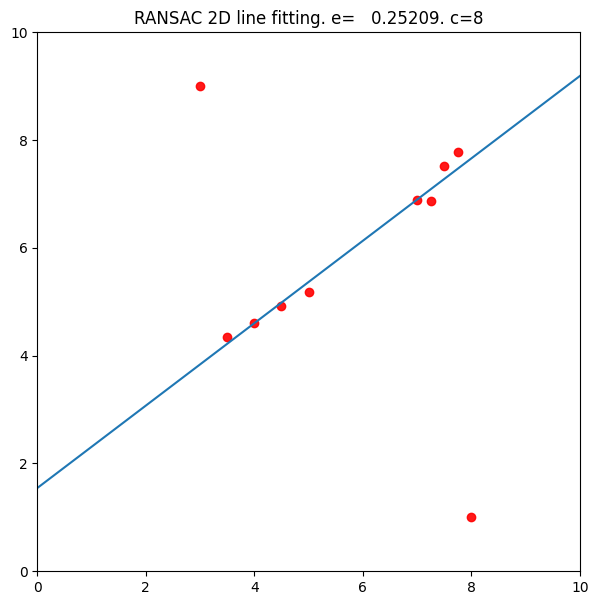

In [40]:
plt.figure(figsize=(7,7))
plt.scatter(data[:,0], data[:,1], c='red', alpha=0.9)
plt.xlim([0,10])
plt.ylim([0,10])
plt.title(f'RANSAC 2D line fitting. e={error_final:10.5}. c={count_final}');
draw_line(theta_final, plt.gca())